# Math Problem Solving: Single vs Multi-Agent Comparison

This notebook compares single-agent and multi-agent approaches for solving GSM8K-style math problems with verifiable outcomes.

**Approaches:**
- **Single Agent**: One agent with all math tools
- **Multi-Agent**: Specialist agents (arithmetic, growth, equations) coordinated by an orchestrator

## Setup & Imports

In [1]:
import asyncio
import time
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pydantic import BaseModel, Field

from cogent import Agent, tool

# Configure matplotlib for SVG output and better styling
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Tool Definitions

Math operation tools with exact computation:

In [2]:
@tool
def calculator(expression: str) -> float:
    """Evaluate a mathematical expression safely.
    
    Args:
        expression: Math expression (e.g., "50 * 3", "200 + 150", "1000 - 105")
    
    Returns:
        The numerical result
    """
    allowed_chars = set("0123456789+-*/()., ")
    if not all(c in allowed_chars for c in expression):
        raise ValueError(f"Expression contains invalid characters: {expression}")
    
    try:
        result = eval(expression)
        return float(result)
    except Exception as e:
        raise ValueError(f"Failed to evaluate '{expression}': {e}")


@tool
def calculate_percentage(value: float, percentage: float) -> float:
    """Calculate a percentage of a value.
    
    Args:
        value: The base value
        percentage: The percentage (e.g., 40 for 40%)
    
    Returns:
        The calculated amount
    """
    return (value * percentage) / 100


@tool
def calculate_growth_rate(initial: float, final: float) -> float:
    """Calculate the growth rate between two values.
    
    Args:
        initial: Starting value
        final: Ending value
    
    Returns:
        Growth rate as a percentage
    """
    if initial == 0:
        raise ValueError("Initial value cannot be zero")
    return ((final - initial) / initial) * 100


@tool
def calculate_compound_growth(initial: float, rates: list[float]) -> float:
    """Calculate final value after applying multiple growth rates sequentially.
    
    Args:
        initial: Starting value
        rates: List of growth rates as percentages (e.g., [15, 23, -8, 31])
    
    Returns:
        Final value after all growth applied
    """
    value = initial
    for rate in rates:
        value = value * (1 + rate / 100)
    return value


@tool
def calculate_average(values: list[float]) -> float:
    """Calculate the arithmetic mean of a list of values.
    
    Args:
        values: List of numbers
    
    Returns:
        The average value
    """
    if not values:
        raise ValueError("Cannot calculate average of empty list")
    return sum(values) / len(values)


@tool
def solve_linear_equation(a: float, b: float) -> float:
    """Solve linear equation: ax + b = 0
    
    Args:
        a: Coefficient of x
        b: Constant term
    
    Returns:
        Solution for x
    """
    if a == 0:
        raise ValueError("Coefficient 'a' cannot be zero in linear equation")
    return -b / a


print("✓ Tools defined")

✓ Tools defined


## Problem Definitions

GSM8K-style math problems with exact answers:

In [3]:
@dataclass
class MathProblem:
    """A math problem with a verifiable answer."""
    question: str
    ground_truth: float
    description: str


PROBLEMS = [
    MathProblem(
        question="""A company's revenue was $2.4M at the start of the year.
It grew 15% in Q1, 23% in Q2, fell 8% in Q3, then grew 31% in Q4.
What was the final revenue? Also calculate the average quarterly growth rate.""",
        ground_truth=4091412.96,
        description="Compound growth"
    ),
    
    MathProblem(
        question="""A store had 150 apples. On Monday, they sold 40% of them.
On Tuesday, they received a shipment that increased their stock by 60 apples.
On Wednesday, they sold 25% of their current stock.
How many apples remain?""",
        ground_truth=112.5,
        description="Multi-step percentages"
    ),
    
    MathProblem(
        question="""A carnival booth made $50 per day selling popcorn.
It made three times as much selling cotton candy each day.
Over 5 days, the booth earned revenue but had to pay $30 rent and $75 for ingredients.
What was the profit after expenses?""",
        ground_truth=895.0,
        description="Revenue & expenses"
    ),
]

print(f"✓ {len(PROBLEMS)} problems defined:")
for i, p in enumerate(PROBLEMS, 1):
    print(f"  {i}. {p.description}: Answer = {p.ground_truth:,.2f}")

✓ 3 problems defined:
  1. Compound growth: Answer = 4,091,412.96
  2. Multi-step percentages: Answer = 112.50
  3. Revenue & expenses: Answer = 895.00


## Structured Output Schema

In [4]:
class MathSolution(BaseModel):
    """Structured output for math problem solutions."""
    reasoning: str = Field(description="Step-by-step explanation of how you solved the problem")
    final_answer: float = Field(description="The final numerical answer to the problem")


print("✓ Output schema defined")

✓ Output schema defined


## Agent Setup

### Single Agent (all tools)

In [5]:
single_agent = Agent(
    name="MathSolver",
    model="gemini:gemini-2.5-pro",
    instructions="""You are an expert mathematics problem solver.
    
Solve problems step-by-step using the available tools.
Show your reasoning clearly, then provide the final numerical answer.""",
    tools=[
        calculator,
        calculate_percentage,
        calculate_growth_rate,
        calculate_compound_growth,
        calculate_average,
        solve_linear_equation,
    ],
)

print("✓ Single agent created")

✓ Single agent created


### Multi-Agent (specialists + orchestrator)

In [6]:
# Arithmetic specialist
arithmetic_expert = Agent(
    name="ArithmeticExpert",
    model="gemini:gemini-2.5-flash",
    instructions="""You are an arithmetic specialist.
    
Use the calculator and percentage tools to perform calculations accurately.
Show each step of your work clearly.""",
    tools=[calculator, calculate_percentage],
)

# Growth/statistics specialist
growth_expert = Agent(
    name="GrowthExpert",
    model="gemini:gemini-2.5-flash",
    instructions="""You are a growth and statistics specialist.
    
Use growth rate and compound growth tools to analyze changes over time.
Calculate averages when needed.""",
    tools=[calculate_growth_rate, calculate_compound_growth, calculate_average],
)

# Equation solver specialist
equation_expert = Agent(
    name="EquationExpert",
    model="gemini:gemini-2.5-flash",
    instructions="""You are an equation solving specialist.
    
Solve linear equations using the provided tool.
Explain the solution process.""",
    tools=[solve_linear_equation],
)

# Orchestrator that delegates to specialists
multi_agent_orchestrator = Agent(
    name="MathOrchestrator",
    model="gemini:gemini-2.5-pro",
    instructions="""You are a math problem orchestrator.
    
Break down complex problems and delegate to specialists:
- ArithmeticExpert: Basic calculations, percentages
- GrowthExpert: Growth rates, compound growth, averages
- EquationExpert: Solving equations

Synthesize their results into a final answer with clear reasoning.""",
    subagents=[arithmetic_expert, growth_expert, equation_expert],
)

print("✓ Multi-agent system created (3 specialists + orchestrator)")

✓ Multi-agent system created (3 specialists + orchestrator)


## Evaluation Functions

In [7]:
@dataclass
class EvaluationResult:
    """Results from solving a problem."""
    problem_description: str
    ground_truth: float
    agent_answer: float | None
    reasoning: str
    duration: float
    input_tokens: int
    output_tokens: int
    total_tokens: int
    tool_calls: int
    correct: bool


async def evaluate_approach(agent: Agent, problem: MathProblem) -> EvaluationResult:
    """Evaluate one problem with one agent."""
    start = time.time()
    response = await agent.run(problem.question, output=MathSolution)
    duration = time.time() - start
    
    # Get structured output - it's wrapped in StructuredResult
    from cogent.agent.output import StructuredResult
    if isinstance(response.content, StructuredResult):
        solution = response.content.data
    else:
        solution = response.content
    
    answer = solution.final_answer if isinstance(solution, MathSolution) else None
    reasoning = solution.reasoning if isinstance(solution, MathSolution) else "No solution provided"
    
    # Check correctness
    correct = answer is not None and answer == problem.ground_truth
    
    # Count tool calls (including subagent tool calls)
    tool_calls = len(response.tool_calls)
    if response.subagent_responses:
        for sub_resp in response.subagent_responses:
            tool_calls += len(sub_resp.tool_calls)
    
    return EvaluationResult(
        problem_description=problem.description,
        ground_truth=problem.ground_truth,
        agent_answer=answer,
        reasoning=reasoning,
        duration=duration,
        input_tokens=response.metadata.tokens.prompt_tokens,
        output_tokens=response.metadata.tokens.completion_tokens,
        total_tokens=response.metadata.tokens.total_tokens,
        tool_calls=tool_calls,
        correct=correct,
    )


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## Run Evaluation

Solve all problems with both approaches:

In [8]:
# Run all evaluations concurrently (3 problems × 2 agents = 6 concurrent tasks)
# Using gather for independent parallel execution
tasks = []
for problem in PROBLEMS:
    tasks.append(evaluate_approach(single_agent, problem))
    tasks.append(evaluate_approach(multi_agent_orchestrator, problem))

results = await asyncio.gather(*tasks)

# Extract results
single_results = [results[i] for i in range(0, len(results), 2)]
multi_results = [results[i] for i in range(1, len(results), 2)]

# Create detailed results DataFrame
df_detailed = pd.DataFrame({
    'Problem': [f'P{i}: {p.description}' for i, p in enumerate(PROBLEMS, 1)],
    'Ground Truth': [p.ground_truth for p in PROBLEMS],
    'Single Answer': [r.agent_answer for r in single_results],
    'Single ✓': ['✓' if r.correct else '✗' for r in single_results],
    'Single Tokens': [r.total_tokens for r in single_results],
    'Single In': [r.input_tokens for r in single_results],
    'Single Out': [r.output_tokens for r in single_results],
    'Single Tools': [r.tool_calls for r in single_results],
    'Single Time': [r.duration for r in single_results],
    'Multi Answer': [r.agent_answer for r in multi_results],
    'Multi ✓': ['✓' if r.correct else '✗' for r in multi_results],
    'Multi Tokens': [r.total_tokens for r in multi_results],
    'Multi In': [r.input_tokens for r in multi_results],
    'Multi Out': [r.output_tokens for r in multi_results],
    'Multi Tools': [r.tool_calls for r in multi_results],
    'Multi Time': [r.duration for r in multi_results],
})

print("✓ Evaluation complete!\n")
display(df_detailed)

✓ Evaluation complete!



,Problem,Ground Truth,Single Answer,Single ✓,Single Tokens,Single In,Single Out,Single Tools,Single Time,Multi Answer,Multi ✓,Multi Tokens,Multi In,Multi Out,Multi Tools,Multi Time
0,P1: Compound growth,4091412.96,4091412.96,✓,1967,1685,282,8,17.479020,4091412.96,✓,11968,10677,1291,26,30.362888
1,P2: Multi-step percentages,112.50,112.50,✓,5512,5232,280,12,33.875642,112.50,✓,14738,13582,1156,28,38.828927
2,P3: Revenue & expenses,895.00,895.00,✓,5450,5180,270,12,25.901763,895.00,✓,14383,13305,1078,26,30.854711


## Results Analysis

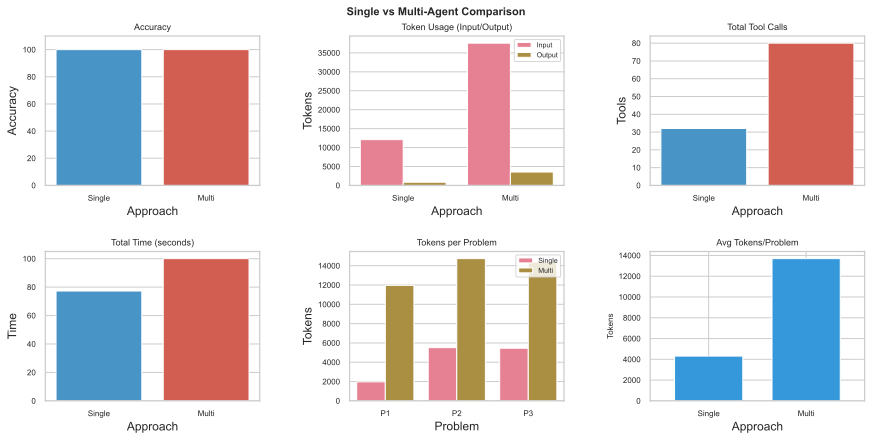

In [21]:
# Calculate metrics using DataFrame operations
single_correct = (df_detailed['Single ✓'] == '✓').sum()
multi_correct = (df_detailed['Multi ✓'] == '✓').sum()
single_total_tokens = df_detailed['Single Tokens'].sum()
multi_total_tokens = df_detailed['Multi Tokens'].sum()
single_input_tokens = df_detailed['Single In'].sum()
multi_input_tokens = df_detailed['Multi In'].sum()
single_output_tokens = df_detailed['Single Out'].sum()
multi_output_tokens = df_detailed['Multi Out'].sum()
single_time = df_detailed['Single Time'].sum()
multi_time = df_detailed['Multi Time'].sum()
single_tools = df_detailed['Single Tools'].sum()
multi_tools = df_detailed['Multi Tools'].sum()

# Create comprehensive visualization
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 3, hspace=0.1, wspace=0.15)

# 1. Accuracy
ax1 = fig.add_subplot(gs[0, 0])
accuracy_data = pd.DataFrame({
    'Approach': ['Single', 'Multi'],
    'Accuracy': [single_correct / len(PROBLEMS) * 100, multi_correct / len(PROBLEMS) * 100]
})
sns.barplot(data=accuracy_data, x='Approach', y='Accuracy', hue='Approach', palette=['#3498db', '#e74c3c'], legend=False, ax=ax1)
ax1.set_ylim(0, 110)
ax1.set_title('Accuracy', fontsize=9)
ax1.tick_params(labelsize=8)

# 2. Token Usage
ax2 = fig.add_subplot(gs[0, 1])
token_data = pd.DataFrame({
    'Approach': ['Single', 'Single', 'Multi', 'Multi'],
    'Type': ['Input', 'Output', 'Input', 'Output'],
    'Tokens': [single_input_tokens, single_output_tokens, multi_input_tokens, multi_output_tokens]
})
sns.barplot(data=token_data, x='Approach', y='Tokens', hue='Type', ax=ax2)
ax2.set_title('Token Usage (Input/Output)', fontsize=9)
ax2.legend(loc='upper right', fontsize=7)
ax2.tick_params(labelsize=8)

# 3. Tool Calls
ax3 = fig.add_subplot(gs[0, 2])
tool_data = pd.DataFrame({'Approach': ['Single', 'Multi'], 'Tools': [single_tools, multi_tools]})
sns.barplot(data=tool_data, x='Approach', y='Tools', hue='Approach', palette=['#3498db', '#e74c3c'], legend=False, ax=ax3)
ax3.set_title('Total Tool Calls', fontsize=9)
ax3.tick_params(labelsize=8)

# 4. Time
ax4 = fig.add_subplot(gs[1, 0])
time_data = pd.DataFrame({'Approach': ['Single', 'Multi'], 'Time': [single_time, multi_time]})
sns.barplot(data=time_data, x='Approach', y='Time', hue='Approach', palette=['#3498db', '#e74c3c'], legend=False, ax=ax4)
ax4.set_title('Total Time (seconds)', fontsize=9)
ax4.tick_params(labelsize=8)

# 5. Per-Problem Tokens
ax5 = fig.add_subplot(gs[1, 1])
problem_data = []
for i, (single, multi) in enumerate(zip(single_results, multi_results), 1):
    problem_data.append({'Problem': f'P{i}', 'Approach': 'Single', 'Tokens': single.total_tokens})
    problem_data.append({'Problem': f'P{i}', 'Approach': 'Multi', 'Tokens': multi.total_tokens})
problem_df = pd.DataFrame(problem_data)
sns.barplot(data=problem_df, x='Problem', y='Tokens', hue='Approach', ax=ax5)
ax5.set_title('Tokens per Problem', fontsize=9)
ax5.legend(loc='upper right', fontsize=7)
ax5.tick_params(labelsize=8)

# 6. Efficiency Averages
ax6 = fig.add_subplot(gs[1, 2])
efficiency_data = {
    'Approach': ['Single', 'Multi'],
    'Tokens/Problem': [single_total_tokens / len(PROBLEMS), multi_total_tokens / len(PROBLEMS)],
    'Time/Problem (s)': [single_time / len(PROBLEMS), multi_time / len(PROBLEMS)]
}
efficiency_df = pd.DataFrame(efficiency_data)
efficiency_df.set_index('Approach')[['Tokens/Problem']].plot(kind='bar', ax=ax6, color=['#3498db', '#e74c3c'], legend=False, width=0.7)
ax6.set_title('Avg Tokens/Problem', fontsize=9)
ax6.set_ylabel('Tokens', fontsize=8)
ax6.tick_params(labelsize=8)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=0)

plt.suptitle('Single vs Multi-Agent Comparison', fontsize=11, fontweight='bold')
plt.show()